<a href="https://colab.research.google.com/github/kHarshit/pothole-segmentation/blob/main/PotholeTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
!mkdir pothole
!unzip '/gdrive/My Drive/PotholeDataset/val.zip' -d pothole/
!unzip '/gdrive/My Drive/PotholeDataset/train.zip' -d pothole/
# rename folder name

In [ ]:
ls -1 pothole/train/ | wc -l

13882


In [ ]:
train_coco = '/gdrive/My Drive/PotholeDataset/via_export_coco_train.json'
val_coco = '/gdrive/My Drive/PotholeDataset/via_export_coco_val.json'

No of training images: 13881  
No of validation images: 2580

The `train` and `val` folders contains annotations in the file `via_region_data.json` in same folder.

# 2. Training Mask R-CNN using detectron2

In [ ]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("pothole_train4", {}, "./output/pothole_train_coco_format.json", "")
register_coco_instances("pothole_val4", {}, "./output/pothole_val_coco_format.json", "")

In [ ]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("pothole_train4")

Metadata(evaluator_type='coco', image_root='', json_file='./output/pothole_val_coco_format.json', name='pothole_val4')

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pothole_train4",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 600    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (pothole)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/13 12:09:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[04/13 12:09:18 d2.engine.train_loop]: Starting training from iteration 0
[04/13 12:09:37 d2.utils.events]:  eta: 0:08:49  iter: 19  total_loss: 1.671  loss_cls: 0.759  loss_box_reg: 0.001  loss_mask: 0.690  loss_rpn_cls: 0.202  loss_rpn_loc: 0.019  time: 0.9297  data_time: 0.0213  lr: 0.000005  max_mem: 3514M
[04/13 12:09:55 d2.utils.events]:  eta: 0:08:27  iter: 39  total_loss: 1.740  loss_cls: 0.635  loss_box_reg: 0.000  loss_mask: 0.688  loss_rpn_cls: 0.318  loss_rpn_loc: 0.030  time: 0.9212  data_time: 0.0074  lr: 0.000010  max_mem: 3514M
[04/13 12:10:14 d2.utils.events]:  eta: 0:08:09  iter: 59  total_loss: 1.375  loss_cls: 0.479  loss_box_reg: 0.006  loss_mask: 0.682  loss_rpn_cls: 0.182  loss_rpn_loc: 0.017  time: 0.9293  data_time: 0.0076  lr: 0.000015  max_mem: 3514M
[04/13 12:10:33 d2.utils.events]:  eta: 0:07:53  iter: 79  total_loss: 1.226  loss_cls: 0.314  loss_box_reg: 0.003  loss_mask: 0.675  loss_rpn_cls: 0.206  loss_rpn_loc: 0.022  time: 0.9307  data_time: 0.0083  lr:

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_pothole_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("pothole_" + d, lambda d=d: get_pothole_dicts("pothole/" + d))
    MetadataCatalog.get("pothole_" + d).set(thing_classes=["pothole"])
pothole_metadata = MetadataCatalog.get("pothole_train")

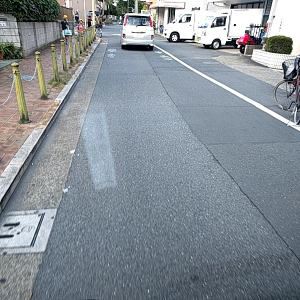

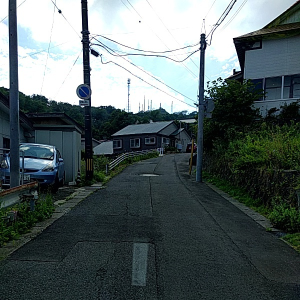

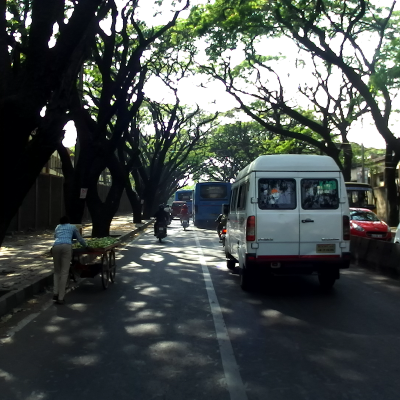

In [ ]:
dataset_dicts = get_pothole_dicts("pothole/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pothole_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pothole_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 600    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (pothole)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[04/13 09:21:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


In [ ]:
trainer.train()

[04/13 09:24:02 d2.engine.train_loop]: Starting training from iteration 0
[04/13 09:24:20 d2.utils.events]:  eta: 0:08:17  iter: 19  total_loss: 1.613  loss_cls: 0.587  loss_box_reg: 0.000  loss_mask: 0.691  loss_rpn_cls: 0.299  loss_rpn_loc: 0.020  time: 0.8757  data_time: 0.0257  lr: 0.000005  max_mem: 2876M
[04/13 09:24:38 d2.utils.events]:  eta: 0:08:10  iter: 39  total_loss: 1.454  loss_cls: 0.522  loss_box_reg: 0.002  loss_mask: 0.689  loss_rpn_cls: 0.267  loss_rpn_loc: 0.019  time: 0.8868  data_time: 0.0063  lr: 0.000010  max_mem: 2876M
[04/13 09:24:57 d2.utils.events]:  eta: 0:08:08  iter: 59  total_loss: 1.316  loss_cls: 0.389  loss_box_reg: 0.002  loss_mask: 0.683  loss_rpn_cls: 0.204  loss_rpn_loc: 0.022  time: 0.9016  data_time: 0.0086  lr: 0.000015  max_mem: 2876M
[04/13 09:25:16 d2.utils.events]:  eta: 0:07:51  iter: 79  total_loss: 1.201  loss_cls: 0.276  loss_box_reg: 0.000  loss_mask: 0.677  loss_rpn_cls: 0.178  loss_rpn_loc: 0.017  time: 0.9151  data_time: 0.0069  lr:

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 877), started 0:11:50 ago. (Use '!kill 877' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
# no of iterations to complete one epoch
13882/512

27.11328125

In [ ]:
# no of epochs
600/27

22.22222222222222

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15   # set the testing threshold for this model
cfg.DATASETS.TEST = ("pothole_val", )
predictor = DefaultPredictor(cfg)

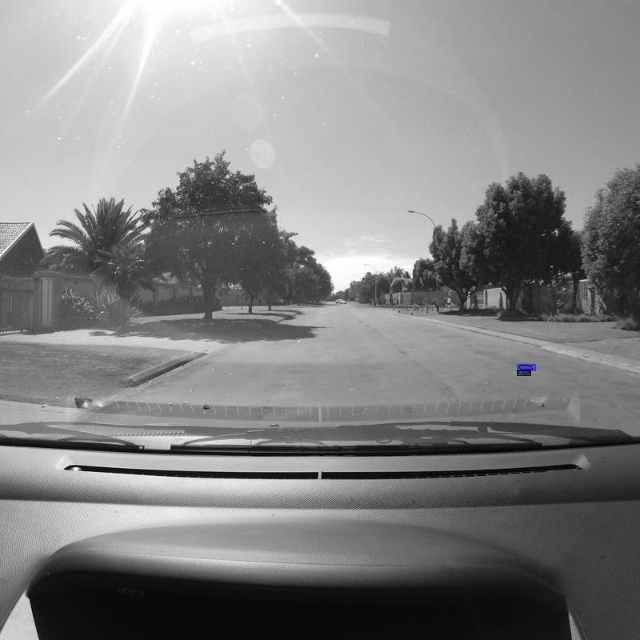

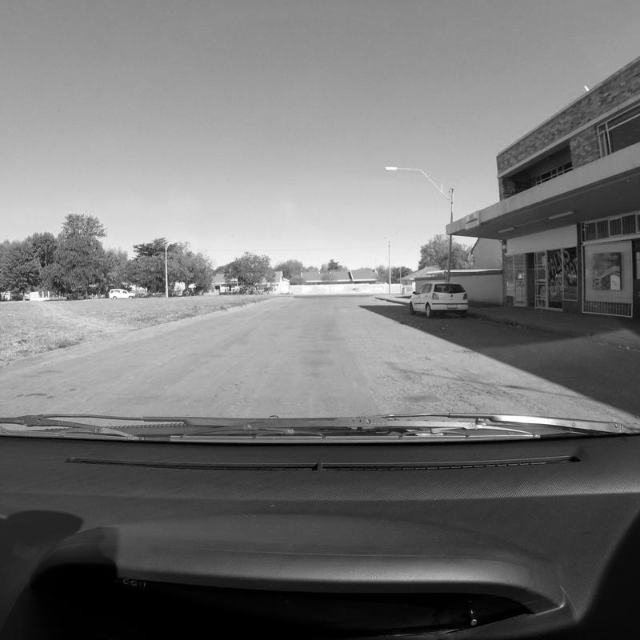

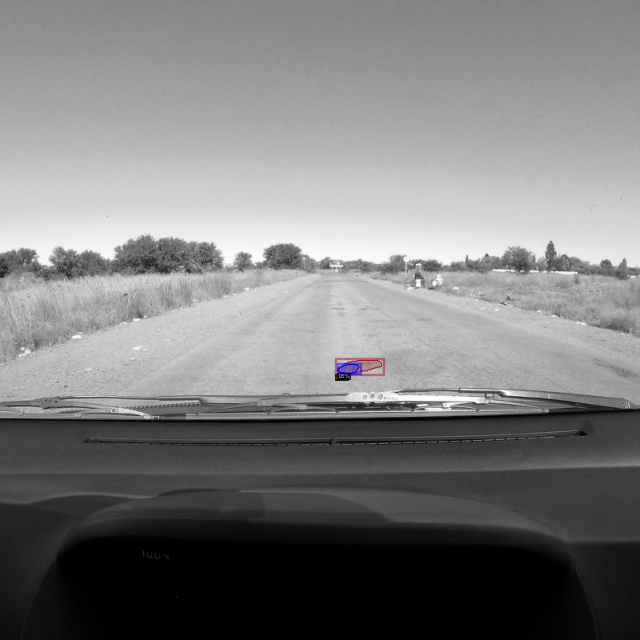

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_pothole_dicts("pothole/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=pothole_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

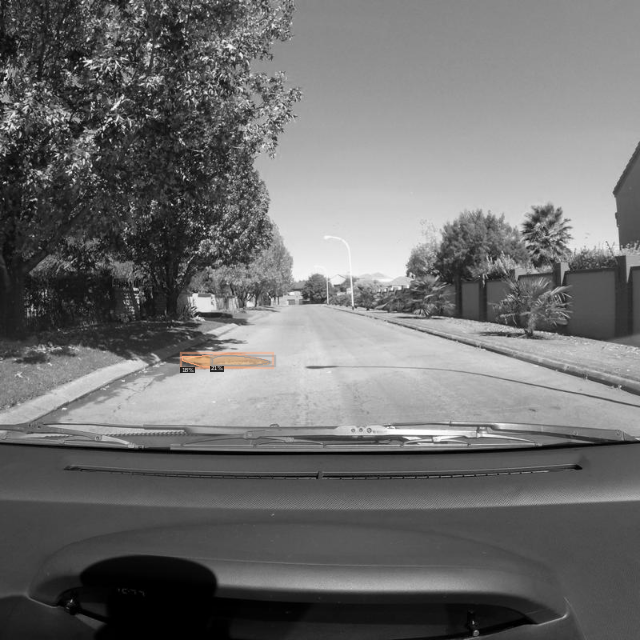

In [ ]:
im = cv2.imread('pothole/val/test_1.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=pothole_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
im = cv2.imread('pothole/val/test_40.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=pothole_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("pothole_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "pothole_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [04/12 08:28:40 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'pothole_val'. Trying to convert it to COCO format ...
[04/12 08:28:40 d2.data.datasets.coco]: Converting dataset annotations in 'pothole_val' to COCO format ...)
[04/12 08:29:05 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/12 08:29:06 d2.data.datasets.coco]: Conversion finished, num images: 2580, num annotations: 454
[04/12 08:29:06 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/pothole_val_coco_format.json
[04/12 08:29:31 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  pothole   | 454          |
|            |              |
[04/12 08:29:31 d2.data.common]: Serializing 2580 elements to byte tensors and concatenating them all ...
[04/12 08:29:31 d2.data.common]: Serialized dataset takes 0.43 MiB
[04/12 08:29:31 d2.evaluation.evaluator]: Start inference on 25

NameError: ignored

In [ ]:
import cv2


# 3. Training YOLACT

In [ ]:
!git clone https://github.com/dbolya/yolact.git

Cloning into 'yolact'...
remote: Enumerating objects: 2933, done.
remote: Total 2933 (delta 0), reused 0 (delta 0), pack-reused 2933
Receiving objects: 100% (2933/2933), 21.19 MiB | 2.82 MiB/s, done.
Resolving deltas: 100% (2000/2000), done.


In [ ]:
pothole_dataset = dataset_base.copy({
    'name': 'Pothole Dataset',

    'train_images': '/content/',
    'train_info':   '/content/pothole_train_coco_format.json',

    'valid_images': '/content/',
    'valid_info':   '/content/pothole_val_coco_format.json',

    'has_gt': True,
    'class_names': ('pothole',),

    'label_map': {0: 1}
})

In [ ]:
ls '/gdrive/My Drive/PotholeDataset'

resnet101_reducedfc.pth  val.zip                     via_region_data_train.json
Test_dataSet/            via_export_coco_train.json  via_region_data_val.json
train.zip                via_export_coco_val.json


In [ ]:
%cd /content/yolact/

/content/yolact


In [ ]:
!cp '/gdrive/My Drive/PotholeDataset/resnet101_reducedfc.pth' ./weights/

In [ ]:
!python train.py --config=yolact_base_config --batch_size=8

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Initializing weights...
Begin training!

[  0]       0 || B: 7.070 | C: 8.965 | M: 8.610 | S: 1.658 | T: 26.303 || ETA: 72 days, 16:10:10 || timer: 7.849
[  0]      10 || B: 7.574 | C: 6.357 | M: 7.576 | S: 1.060 | T: 22.566 || ETA: 13 days, 8:05:27 || timer: 0.739
[  0]      20 || B: 6.718 | C: 5.346 | M: 7.024 | S: 0.641 | T: 19.729 || ETA: 10 days, 16:36:12 || timer: 0.865
[  0]      30 || B: 6.374 | C: 4.734 | M: 7.044 | S: 0.457 | T: 18.609 || ETA: 9 days, 15:27:05 || timer: 0.787
[  0]      40 || B: 6.259 | C: 4.397 | M: 7.202 | S: 0.360 | T: 18.219 || ETA: 9 days, 4:24:16 || timer: 0.938
[  0]      50 || B: 6.184 | C: 4.134 | M: 7.212 | S: 0.303 | T: 17.834 || ETA: 9 days, 0:53:36 || timer: 0.915
[  0]      60 || B: 6.043 | C: 3.939 | M: 7.184 | S: 0.265 | T: 17.431 || ETA: 8 days, 19:43:52 || timer: 0.846
[  0]    

In [ ]:
!gsutil cp /content/yolact/weights/yolact_base_11_2027_interrupt.pth '/gdrive/My Drive/PotholeDataset/' 

Copying file:///content/yolact/weights/yolact_base_11_2027_interrupt.pth...
-
Operation completed over 1 objects/189.7 MiB.                                    


In [ ]:
# %cd yolact/
!cp '/gdrive/My Drive/PotholeDataset/yolact_base_11_2027_interrupt.pth' ./weights/

In [ ]:
!python eval.py --trained_model=weights/yolact_base_11_2027_interrupt.pth --benchmark --max_images=1000

Config not specified. Parsed yolact_base_config from the file name.

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading model... Done.

Processing Images  ████████░░░░░░░░░░░░░░░░░░░░░░     91 /    310 (29.35%)    14.31 fps        Warning: Augmentation output an example with no ground truth. Resampling...
Processing Images  █████████████████████░░░░░░░░░    225 /    310 (72.58%)    14.24 fps        Warning: Augmentation output an example with no ground truth. Resampling...
Processing Images  ██████████████████████████████    310 /    310 (100.00%)    14.24 fps        

Stats for the last frame:

      Name      | Time (ms)  
----------------+------------
  Network Extra |     0.2423 
       backbone |    11.5140 
            fpn |     0.7282 
          proto |     0.5686 
     pred_heads |     2.2930 
     makepriors |     0.0167 
         Detect |    44.7507 
    Postprocess |     1.2160 
           Copy |     5.9875 
           Sync |     0.057

In [ ]:
mkdir /content/output_images

In [ ]:
!python eval.py --trained_model=weights/yolact_base_11_2027_interrupt.pth --score_threshold=0.25 --top_k=15 --images=/content/pothole/val/:/content/output_images/

**Too many false positives!**

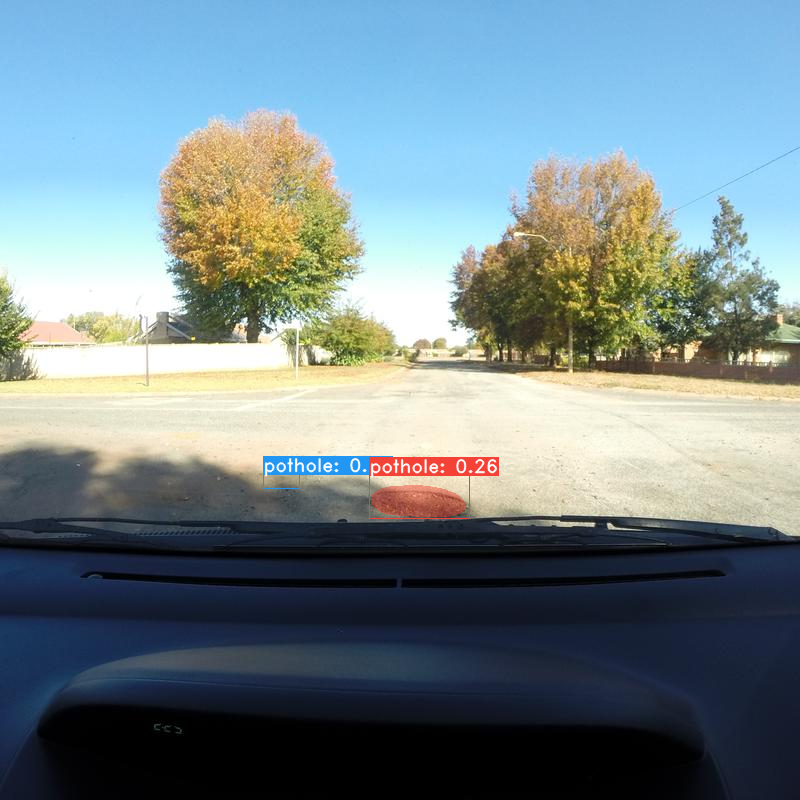

In [ ]:
from IPython.display import Image
Image('/content/output_images/test_10.png')

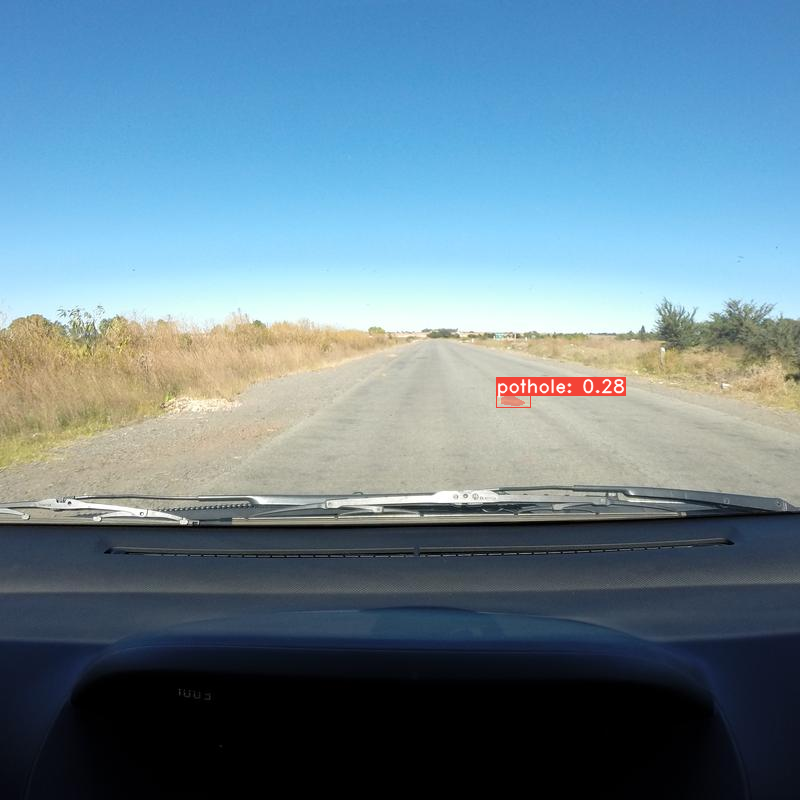

In [ ]:
Image('/content/output_images/test_108.png')

In [ ]:
# !mkdir /content/test
!cp '/gdrive/My Drive/PotholeDataset/Test_dataSet/test_dataset/Adachi_20170911112605.jpg' /content/test/

In [ ]:
!python eval.py --trained_model=weights/yolact_base_11_2027_interrupt.pth --score_threshold=0.25 --top_k=15 --images=/content/pothole/val/:/content/output_images/

In [ ]:
ls '/gdrive/My Drive/PotholeDataset/Test_dataSet/test_dataset/'

 171.jpg                    '\frame3.jpg'   Muroran_20170920113720.jpg
 351.jpg                     IMG_4453.JPG   Muroran_20170921100101.jpg
 4173.jpg                    IMG_4991.JPG   pgm-bw-112-_98.jpg
 5587.jpg                    IMG_6746.JPG   pgm-bw-115-_145.jpg
 Adachi_20170911112605.jpg   IMG_9567.JPG   test_275.jpg


In [ ]:
!mkdir /content/test_output

In [ ]:
!python eval.py --trained_model=weights/yolact_base_11_2027_interrupt.pth --score_threshold=0.25 --top_k=15 --image=/content/pothole/train/373.jpg:/content/test_output/373.jpg

Config not specified. Parsed yolact_base_config from the file name.

Loading model... Done.


In [ ]:
Image('/content/test_output/373.jpg')

In [ ]:
!nvidia-smi

Wed Apr 15 05:36:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  